In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
import json
import sys

In [3]:
df_disorder = pd.read_csv('./project_pipeline/data/disorder.tsv', sep='\t').astype('object')
df_proteins = pd.read_csv('./project_pipeline/data/proteins.tsv', sep='\t').astype('object')
uniprot_unique = df_disorder['uniprot'].unique()
minimum_values = []
for uniprot in uniprot_unique:
    uniprot_df = df_disorder[df_disorder['uniprot'] == uniprot]
    minimum_value = uniprot_df['2_comp'].min()
    minimum_values.append(minimum_value)

df_mins = df_disorder
for i in range(len(df_disorder)):
    if float(df_mins.loc[i, '2_comp']) not in minimum_values:
        df_mins.drop(index=i, inplace=True)

df_copy = df_mins.drop_duplicates(keep='first').reset_index()

def stringtolist(string):
    if ',' in string:
        bounds_str_list = string.split(',')
        bounds_int_list = []
        for bounds in bounds_str_list:
            bounds = bounds.split('-')
            bounds = [int(i) for i in bounds]
            for bound in bounds:
                bounds_int_list.append(bound)

    else:
        bounds_str_list = string.split('-')
        bounds_int_list = [int(i) for i in bounds_str_list]

    return bounds_int_list
 
# function to calculate
# Small result between
# two arrays
def findSmallestDifference(A, B, m, n):
 
    # Sort both arrays
    # using sort function
    A.sort()
    B.sort()
 
    a = 0
    b = 0
 
    # Initialize result as max value
    result = sys.maxsize
 
    # Scan Both Arrays upto
    # sizeof of the Arrays
    while (a < m and b < n):
     
        if (abs(A[a] - B[b]) < result):
            result = abs(A[a] - B[b])
 
        # Move Smaller Value
        if (A[a] < B[b]):
            a += 1
 
        else:
            b += 1
    # return final sma result
    return result
 
# Driver Code

for i in range(len(df_copy)):
    region_1 = df_copy.loc[i, 'region_1']
    region_2 = df_copy.loc[i, 'region_2']
    region_1_bounds = stringtolist(region_1)
    region_2_bounds = stringtolist(region_2)
    len1 = len(region_1_bounds)
    len2 = len(region_2_bounds)

    smallest_dif = findSmallestDifference(region_1_bounds, region_2_bounds, len1, len2)
    df_copy.loc[i, 'smallest_dif'] = smallest_dif

# df_copy.to_csv('df_copy.tsv', sep='\t', index=False)

In [4]:
df = pd.read_csv('./df_copy.tsv', sep='\t').astype('object')
df = df.astype({'smallest_dif': 'float'})
df_min = df[['conformation', 'uniprot', 'smallest_dif']]

In [5]:
plt.style.use('ggplot')

c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

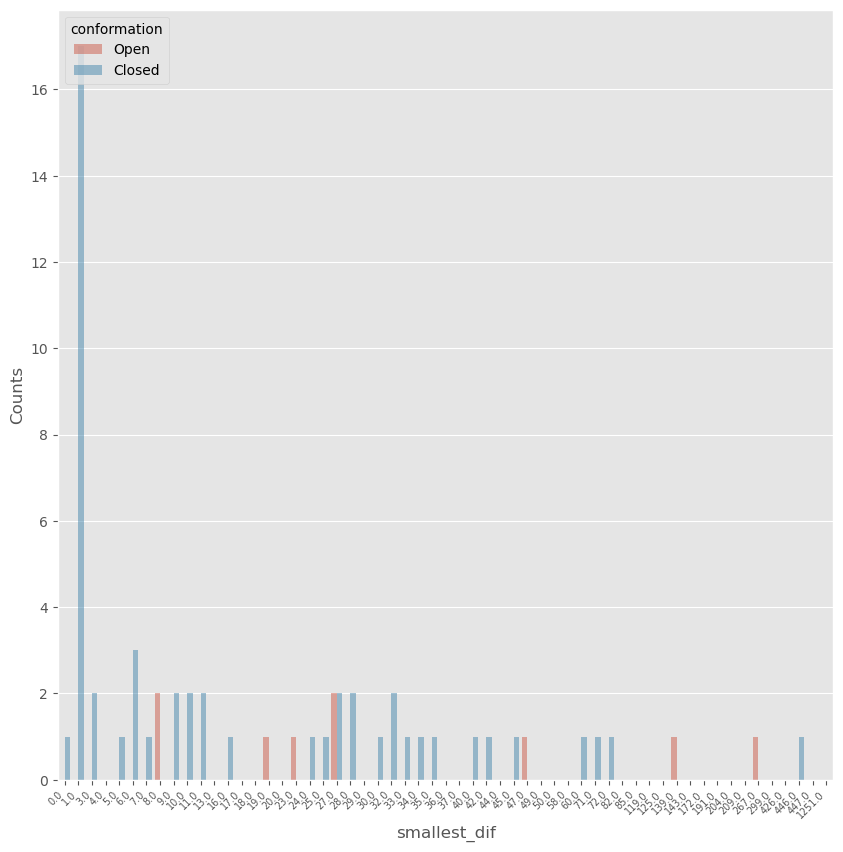

In [18]:
# Make a dataframe with the number of counts of each conformation at each minimum sequence distance
df_min = df_min[['conformation', 'smallest_dif']]
df_min['Counts'] = df_min.groupby(['smallest_dif'])['conformation'].transform('count')

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sns.barplot(x='smallest_dif', y='Counts', hue='conformation', data=df_min.drop_duplicates(), alpha=0.5)
plt.xticks(rotation=45, fontsize='x-small', ha='right')

plt.savefig('./project_pipeline/data/figures/seq_dist_correlation_counts.png', dpi=300, bbox_inches='tight')

c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

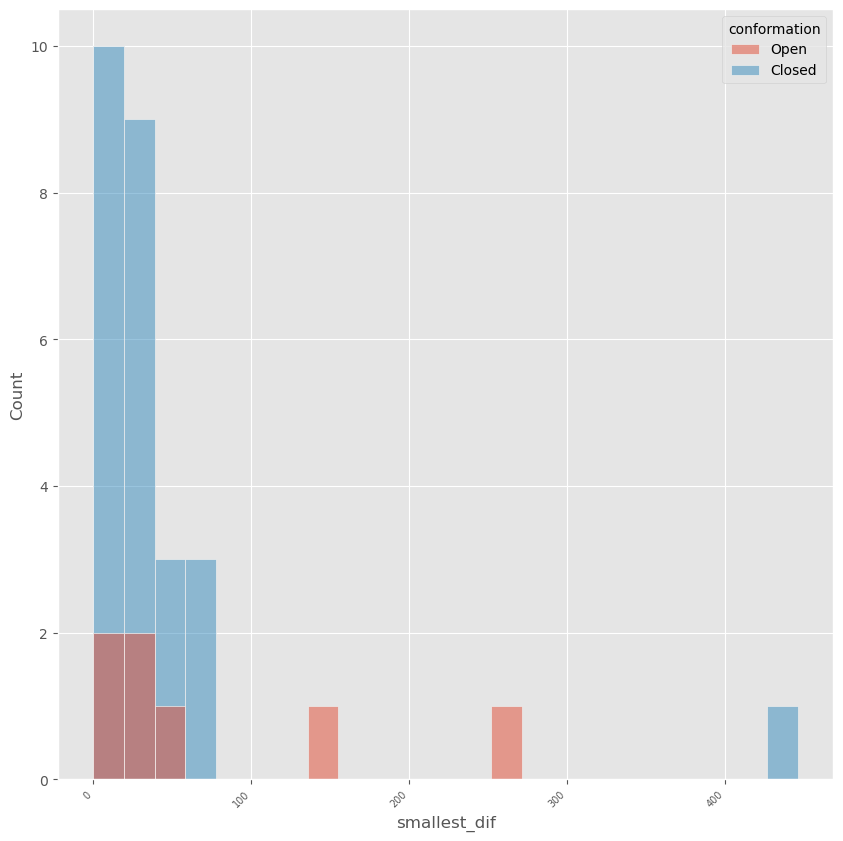

In [17]:
df_min = df_min[['conformation', 'smallest_dif']]

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sns.histplot(x='smallest_dif', hue='conformation', data=df_min.drop_duplicates(), alpha=0.5)
plt.xticks(rotation=45, fontsize='x-small', ha='right')

plt.savefig('./project_pipeline/data/figures/seq_dist_correlation.png', dpi=300, bbox_inches='tight')

c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\User\miniconda3\envs\test_snek\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


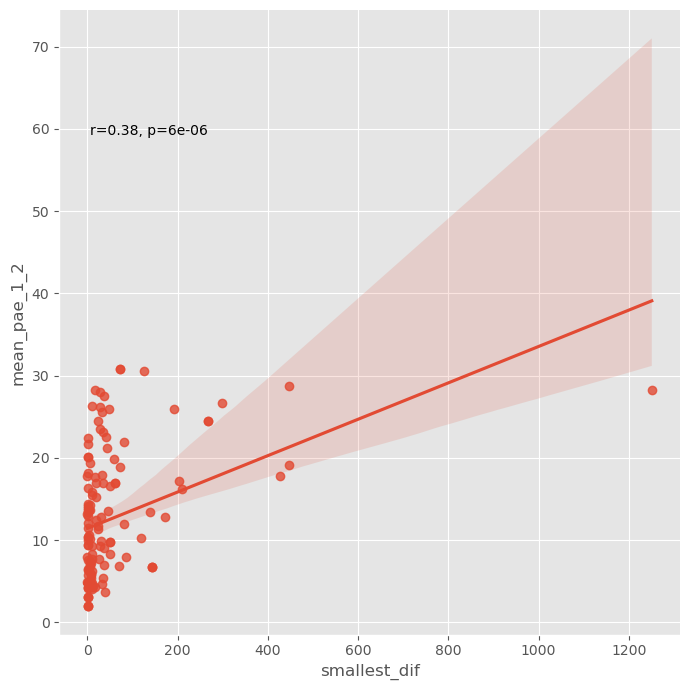

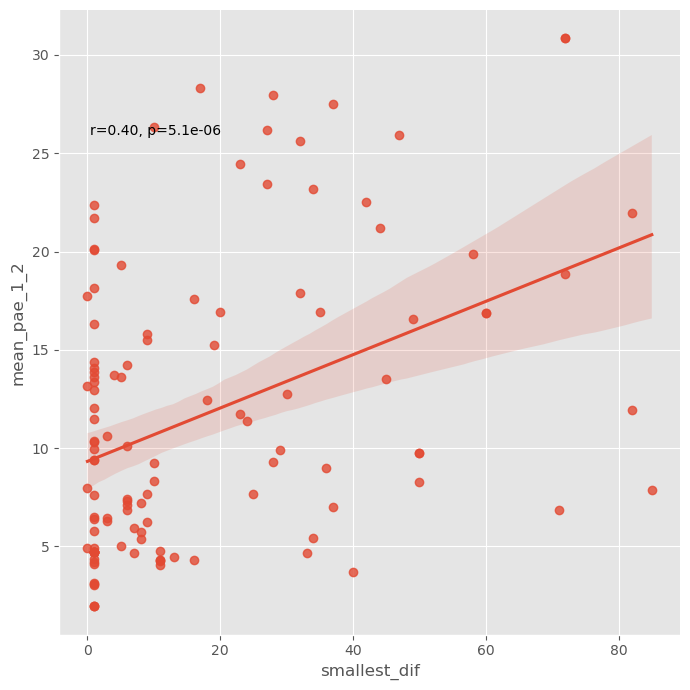

In [19]:
df_num = df[['mean_pae_1_2', 'smallest_dif']].astype('float')
df_no_outlier = df_num[df_num['smallest_dif'] < 100.0]

g = sns.lmplot(x='smallest_dif', y='mean_pae_1_2', data=df_num, height=7, aspect=1)
g2 = sns.lmplot(x='smallest_dif', y='mean_pae_1_2', data=df_no_outlier, height=7, aspect=1)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['smallest_dif'], data['mean_pae_1_2'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
g2.map_dataframe(annotate)

g.savefig('./project_pipeline/data/figures/correlation_smallest_dif_pae.png')
g2.savefig('./project_pipeline/data/figures/correlation_smallest_dif_pae_no_outlier.png')